In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import math 
import cmath
import matplotlib.pyplot as plt
from matplotlib import cm,rc
import os
import seaborn as sns
import scipy.linalg as la
from mpl_toolkits import mplot3d

In [4]:
path_Lammps='C:/Users/esmak/Documents/PhD/LAMMPS/Sphere/Hookean force/3000 particles dt=0.001/'
file='dump'

In [5]:
#LAMMPS output contains the information in the columns
#c_voro[1] contains Voronoi volume of each particle, see LAMMPS documentation for more details about the output
column_list=['ITEM:','ATOMS','mol', 'x','y','z', 'radius', 'c_voro[1]', 'c_coordination','c_kinetic', 'c_voro[2]', 'c_order[1]', 'c_order[2]','c_order[3]']
traj = pd.read_csv(path_Lammps+file+'.dat',
                   skiprows=17,
                   sep='\s+',
                   dtype='double',
                   usecols=column_list)

In [6]:
traj.head()

,ITEM:,ATOMS,mol,x,y,z,radius,c_voro[1],c_coordination,c_kinetic,c_voro[2],c_order[1],c_order[2],c_order[3]
0,351.0,1.78622,0.510368,0.499314,0.5,0.794898,7.0,1.237580e-11,12.0,0.0,0.0,0.0,4.75203,NaN
1,558.0,2.75002,0.243781,0.495433,0.5,0.802007,5.0,1.187700e-11,10.0,0.0,0.0,0.0,4.78334,NaN
2,63.0,3.76167,0.007314,0.499151,0.5,0.845930,5.0,2.740260e-12,11.0,0.0,0.0,0.0,5.01001,NaN
3,99.0,5.45917,0.474968,0.498258,0.5,0.873147,4.0,1.593150e-11,11.0,0.0,0.0,0.0,5.05910,NaN
4,187.0,6.44353,0.299029,0.499769,0.5,0.859899,3.0,7.771050e-11,11.0,0.0,0.0,0.0,5.01231,NaN


In [7]:
traj=traj.shift(periods=2,axis='columns')
traj=traj[['mol','x','y','z','radius','c_voro[1]']]
data=traj.rename(columns={'mol':'id','c_voro[1]':'Voronoi_volume'})
data.head()

,id,x,y,z,radius,Voronoi_volume
0,351.0,1.78622,0.510368,0.499314,0.5,0.794898
1,558.0,2.75002,0.243781,0.495433,0.5,0.802007
2,63.0,3.76167,0.007314,0.499151,0.5,0.845930
3,99.0,5.45917,0.474968,0.498258,0.5,0.873147
4,187.0,6.44353,0.299029,0.499769,0.5,0.859899


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3000 non-null   float64
 1   x               3000 non-null   float64
 2   y               3000 non-null   float64
 3   z               3000 non-null   float64
 4   radius          3000 non-null   float64
 5   Voronoi_volume  3000 non-null   float64
dtypes: float64(6)
memory usage: 140.8 KB


In [9]:
diameter=data.loc[0,'radius']*2    #diameter of a particle in the system
N_p=len(data)                      #Number of particles in the system
L_x=10                             #Length of the box in x-direction
L_y=10                             #Length of the box in y-direction
L_z=data['z'].max()-data['z'].min()   #Packing height
data['id']=range(0,N_p)
data.head()

,id,x,y,z,radius,Voronoi_volume
0,0,1.78622,0.510368,0.499314,0.5,0.794898
1,1,2.75002,0.243781,0.495433,0.5,0.802007
2,2,3.76167,0.007314,0.499151,0.5,0.845930
3,3,5.45917,0.474968,0.498258,0.5,0.873147
4,4,6.44353,0.299029,0.499769,0.5,0.859899


In [10]:
#The system has periodic boundary conditions in lateral directions (x-y plane) and the box is bounded 
#in the z-direction by a rough surface made of randomly packed spheres at the bottom. To detect contacts between particles
#near the boundaries, ghost particles are created by shifting the original particle positions according to the periodicity

#Cn represent the number of contacting(nearest) particles of a reference particle 
#Nn represent the number of particles that are within a distance from the reference particle
#nearest saves ids of the contacting particles of the reference particle
#neighbors saves ids of the neighbor particles of the reference one

def periodic(data):

    full_data=pd.DataFrame()
    
    for i in range(0,3):
        for j in range(0,3):
            ghost=data.copy()
            ghost['x']=data['x']+(i-1)*L_x
            ghost['y']=data['y']+(j-1)*L_y
            
            if i==1 and j==1:
                ghost['original']='original'
            else:
                ghost['original']='ghost'
                
            full_data=pd.concat([full_data,ghost],axis=0)
            full_data[['ii','jj','kk','Cn','Nn']]=pd.DataFrame([[0,0,0,0,0]],index=full_data.index)
            full_data['nearest']=full_data.apply(lambda x:[], axis=1)
            full_data['neighbors']=full_data.apply(lambda x:[], axis=1)

    full_data=full_data.astype('object')
    print(full_data.head(),full_data.info())
    return full_data

In [41]:
#To reduce computation time for detecting contacts, the system is divided into small boxes, so for each reference particle,
#we check only the particles that belong to the nearest boxes instead of looping over all the particles in the system.

def tessellation(full_data,diameter,nk=100):
    
    #nk is the maximum number of particles that one box can have

    N_full=len(full_data)   #the total number of particles including ghost ones in the system

    z_max=full_data['z'].max()
    z_min=full_data['z'].min()

    y_max=full_data['y'].max()
    y_min=full_data['y'].min()

    x_max=full_data['x'].max()
    x_min=full_data['x'].min()

    dx=2*diameter            #the width of each box in x-direction
    dy=2*diameter            #the width of each box in y-direction
    dz=2*diameter            #the width of each box in z-direction

    x_width=x_max-x_min      #the total length of the packing including ghost particles in x-direction
    y_width=y_max-y_min      #the total length of the packing including ghost particles in y-direction
    z_height=z_max-z_min     #the total length of the packing including ghost particles in z-direction

    nbx=int(x_width/dx+2)     #number of boxes in x-direction
    nby=int(y_width/dy+2)     #number of boxes in y-direction
    nbz=int(z_height/dz+2)    #number of boxes in z-direction

    Box=np.zeros((nbx,nby,nbz,nk))      #maps each particle index to the box that it belongs to
    NBox=np.zeros((nbx,nby,nbz,1))      #saves the total number of particles in each box

    #Mapping the index of each particle to the box that it belongs to
    for i in range (0,N_full):

        ii=int((full_data.iloc[i,1]+L_x)/dx)
        jj=int((full_data.iloc[i,2]+L_y)/dy)
        kk=int((full_data.iloc[i,3]-z_min)/dz)
        
        Box[ii,jj,kk,int(NBox[ii,jj,kk])]=i
        NBox[ii,jj,kk]=NBox[ii,jj,kk]+1
    
        #saves the box position of each particle to full_data  
        full_data.iloc[i,7:10]=[ii,jj,kk]
        
    return NBox,Box,nbx,nby,nbz,full_data

In [33]:
#filter the original data from the full_data (includes the information of only actual particles)
def filter_data(full_data):
    
    original_data=full_data.loc[full_data['original']=='original']
    #original_data=original_data.set_index('id')
    #original_data.index=original_data.index.astype('int64')
    original_data.loc[:,['ii','jj','kk','Cn','Nn']]=original_data.loc[:,['ii','jj','kk','Cn','Nn']].astype('int64')
    #original_data=original_data.sort_index()
    print(original_data.head())
    return original_data

In [14]:
def rdf(original_data,full_data,N_p,L_x,L_y,L_z,nbx,nby,nbz,n_layer=400,shell_t=0.025):
#Calculate radial distribution function

    rdf_s=np.zeros((n_layer,2))
    
    for i, row in original_data.iterrows():

        ii=row['ii']
        jj=row['jj']
        kk=row['kk']

        for ni in range(ii-5,ii+6):
            if (ni>=0 and ni<nbx): 
                for nj in range(jj-5,jj+6):
                    if (nj>=0 and nj<nby):
                        for nk in range(kk-5,kk+6):
                            if (nk>=0 and nk<nbz):
                                for s in range(0,int(NBox[ni,nj,nk])):

                                    j=int(Box[ni,nj,nk,s])
                                    x_distance=row['x']-full_data.iloc[j,1]
                                    y_distance=row['y']-full_data.iloc[j,2]
                                    z_distance=row['z']-full_data.iloc[j,3]
                                    distance=math.sqrt(x_distance**2+y_distance**2+z_distance**2) 

                                    i_rdf=distance//shell_t
                                    if int(i_rdf)<n_layer:
                                        
                                        rdf_s[int(i_rdf),1]+=1
                                        

    ro=N_p/(L_x*L_y*L_z)

    for i in range (1,n_layer):
        
        rdf_s[i,0]=i*shell_t
        rdf_s[i,1]=rdf_s[i,1]/(N_p*4*math.pi*math.pow(i*shell_t,2)*shell_t*ro)
    
    rdf_s[0,1]=0 
    
    return rdf_s

In [43]:
def contact_calculations(original_data,full_data,nbx,nby,nbz,delta):
#Calculate the contact number, the neighbor number, and save their ids, delta is the cutoff distance
    for i, row in original_data.iterrows():

        ii=row['ii']
        jj=row['jj']
        kk=row['kk']

        n_nearest=0
        n_neighbor=0
        nearest_list=[]
        neighbors_list=[]

        for ni in range(ii-1,ii+2):
            if (ni>=0 and ni<nbx): 
                for nj in range(jj-1,jj+2):
                    if (nj>=0 and nj<nby):
                        for nk in range(kk-1,kk+2):
                            if (nk>=0 and nk<nbz):
                                for s in range(0,int(NBox[ni,nj,nk])):

                                    j=int(Box[ni,nj,nk,s])
                                    x_distance=row['x']-full_data.iloc[j,1]
                                    y_distance=row['y']-full_data.iloc[j,2]
                                    z_distance=row['z']-full_data.iloc[j,3]
                                    distance=math.sqrt(x_distance**2+y_distance**2+z_distance**2) 

                                    cutoff_neighbor=diameter+delta
                                    
                                    if distance<=diameter:
                                        n_nearest+=1   
                                        nearest_list.append(j)
                                        
                                    if distance<=cutoff_neighbor:
                                        n_neighbor+=1   
                                        neighbors_list.append(j)
                                       

        original_data.loc[i,'Cn']=n_nearest-1
        original_data.loc[i,'Nn']=n_neighbor-1
        original_data.at[i,'nearest']=list(map(int,nearest_list))
        original_data.at[i,'neighbors']=list(map(int,neighbors_list))
    
    return original_data

In [35]:
#Local and global bond orientational order parameters measured for random sphere packings
#the neighbourhood is already defined in the contact calculations (by delta)
#q4 and q6 are the local orientational order parameters defined by Steinhardt et al.(1983)
#q4tildabar and q6tildabar are the local orientational order parameters introduced by Eslami et al.(2018) to improve 
#the determination of liquid and different crystallized phases.

def order_parameters(full_data,original_data,N_p):

    #Calculation of spherical harmonics of the particles 
    q2m_r=np.zeros((N_p,10),dtype=np.complex_)          #spherical harmonics of each bond for 2th degree
    q2m=np.zeros((N_p,5),dtype=np.complex_)             #averaged spherical harmonics for 2th degree over Ni neighbours of the reference particle
    q2=np.zeros((N_p,1))              #the local orientational order parameter q2 for each reference particle
    Q2m=np.zeros((5,1),dtype=np.complex_)                 #the average taken over all the bonds in the packing
    q4m_r=np.zeros((N_p,10),dtype=np.complex_)          #spherical harmonics of each bond for 4th degree
    q4m=np.zeros((N_p,9),dtype=np.complex_)             #averaged spherical harmonics for 4th degree over Ni neighbours of the dimers
    q4=np.zeros((N_p,1))              #the local orientational order parameter q4 for the dimers 
    Q4m=np.zeros((9,1),dtype=np.complex_)                 #the average taken over all the bonds in the packing
    q6m_r=np.zeros((N_p,14),dtype=np.complex_)          #spherical harmonics of each bond for 6th degree
    q6m=np.zeros((N_p,13),dtype=np.complex_)            #averaged spherical harmonics for 6th degree over Ni neighbours of the dimers 
    q6=np.zeros((N_p,1))              #the local orientational order parameter q6 for the dimers 
    Q6m=np.zeros((13,1),dtype=np.complex_)                #the average taken over all the bonds in the packing
    
    for i, row in original_data.iterrows():

        for j in row['neighbors']:

                x=row['x']-full_data.iloc[j,1]
                y=row['y']-full_data.iloc[j,2]
                z=row['z']-full_data.iloc[j,3]
    
                distance=math.sqrt(x**2+y**2+z**2)

                if distance>0:
                    
                    q2m_r[i,0]=q2m_r[i,0]+1
                    q4m_r[i,0]=q4m_r[i,0]+1 
                    q6m_r[i,0]=q6m_r[i,0]+1 
    
                    q2m_r[i,1]=q2m_r[i,1]+1/4*math.sqrt(7.5/math.pi)*complex(x,-y)**2/(distance**2)
                    q2m_r[i,2]=q2m_r[i,2]+1/2*math.sqrt(7.5/math.pi)*complex(x,-y)*z/(distance**2)
                    q2m_r[i,3]=q2m_r[i,3]+1/4*math.sqrt(5/math.pi)*(3*z**2-distance**2)/(distance**2)
                    q2m_r[i,4]=q2m_r[i,4]-1/2*math.sqrt(7.5/math.pi)*complex(x,y)*z/(distance**2)
                    q2m_r[i,5]=q2m_r[i,5]+1/4*math.sqrt(7.5/math.pi)*complex(x,y)**2/(distance**2)

                    q4m_r[i,1]=q4m_r[i,1]+3/16*math.sqrt(17.5/math.pi)*complex(x,-y)**4/(distance**4)
                    q4m_r[i,2]=q4m_r[i,2]+3/8*math.sqrt(35/math.pi)*complex(x,-y)**3*z/(distance**4)
                    q4m_r[i,3]=q4m_r[i,3]+3/8*math.sqrt(2.5/math.pi)*complex(x,-y)**2*(7*z*z-distance**2)/(distance**4)
                    q4m_r[i,4]=q4m_r[i,4]+3/8*math.sqrt(5/math.pi)*complex(x,-y)*z*(7*z**2-3*distance**2)/(distance**4)
                    q4m_r[i,5]=q4m_r[i,5]+3/16*math.sqrt(1/math.pi)*(35*z**4-30*z**2*distance**2+3*distance**4)/(distance**4)
                    q4m_r[i,6]=q4m_r[i,6]-3/8*math.sqrt(5/math.pi)*complex(x,y)*z*(7*z**2-3*distance**2)/(distance**4)
                    q4m_r[i,7]=q4m_r[i,7]+3/8*math.sqrt(2.5/math.pi)*complex(x,y)**2*(7*z**2-distance**2)/(distance**4)
                    q4m_r[i,8]=q4m_r[i,8]-3/8*math.sqrt(35/math.pi)*complex(x,y)**3*z/(distance**4)
                    q4m_r[i,9]=q4m_r[i,9]+3/16*math.sqrt(17.5/math.pi)*complex(x,y)**4/(distance**4)

                    q6m_r[i,1]=q6m_r[i,1]+1/64*math.sqrt(3003/math.pi)*complex(x,-y)**6/(distance**6)
                    q6m_r[i,2]=q6m_r[i,2]+3/32*math.sqrt(1001/math.pi)*complex(x,-y)**5*z/(distance**6)
                    q6m_r[i,3]=q6m_r[i,3]+3/32*math.sqrt(45.5/math.pi)*complex(x,-y)**4*(11*z**2-distance**2)/(distance**6)
                    q6m_r[i,4]=q6m_r[i,4]+1/32*math.sqrt(1365/math.pi)*complex(x,-y)**3*z*(11*z**2-3*distance**2)/(distance**6)
                    q6m_r[i,5]=q6m_r[i,5]+1/64*math.sqrt(1365/math.pi)*complex(x,-y)**2*(33*z**4-18*distance**2*z**2+distance**4)/(distance**6)
                    q6m_r[i,6]=q6m_r[i,6]+1/16*math.sqrt(136.5/math.pi)*complex(x,-y)*z*(33*z**4-30*distance**2*z**2+5*distance**4)/(distance**6)
                    q6m_r[i,7]=q6m_r[i,7]+1/32*math.sqrt(13/math.pi)*(231*(z/distance)**6-315*(z/distance)**4+105*(z/distance)**2-5)
                    q6m_r[i,8]=q6m_r[i,8]-1/16*math.sqrt(136.5/math.pi)*complex(x,y)*z*(33*z**4-30*distance**2*z**2+5*distance**4)/(distance**6)
                    q6m_r[i,9]=q6m_r[i,9]+1/64*math.sqrt(1365/math.pi)*complex(x,y)**2*(33*z**4-18*distance**2*z**2+distance**4)/(distance**6)
                    q6m_r[i,10]=q6m_r[i,10]-1/32*math.sqrt(1365/math.pi)*complex(x,y)**3*z*(11*z**2-3*distance**2)/(distance**6)
                    q6m_r[i,11]=q6m_r[i,11]+3/32*math.sqrt(45.5/math.pi)*complex(x,y)**4*(11*z**2-distance**2)/(distance**6)
                    q6m_r[i,12]=q6m_r[i,12]-3/32*math.sqrt(1001/math.pi)*complex(x,y)**5*z/(distance**6)
                    q6m_r[i,13]=q6m_r[i,13]+1/64*math.sqrt(3003/math.pi)*complex(x,y)**6/(distance**6)


    Nb=0
    for i in range(0,N_p):
        
        Nb=Nb+q2m_r[i,0] 
        if q2m_r[i,0]>0:      
            for l in range(1,6):
                q2m[i,l-1]=q2m_r[i,l]/q2m_r[i,0]                                                                                                    
            for j in range(1,10):
                q4m[i,j-1]=q4m_r[i,j]/q4m_r[i,0]
            for k in range(1,14):
                q6m[i,k-1]=q6m_r[i,k]/q6m_r[i,0]       


    for i in range(0,N_p):
       
        total_sum=0
        for l in range(0,5):
            total_sum=total_sum+math.pow(abs(q2m[i,l]),2)
        q2[i,0]=math.sqrt(4*math.pi/5*total_sum)

        total_sum=0
        for j in range(0,9):
            total_sum=total_sum+math.pow(abs(q4m[i,j]),2)
        q4[i,0]=math.sqrt(4*math.pi/9*total_sum)

        total_sum=0
        for j in range(0,13):
            total_sum=total_sum+math.pow(abs(q6m[i,j]),2)
        q6[i,0]=math.sqrt(4*math.pi/13*total_sum)

    total_sum2=0
    total_sum4=0
    total_sum6=0
    N_bulk=0        #Number of bulk particles
    zmax=original_data['z'].max()-5*diameter
    zmin=original_data['z'].min()+3*diameter
    
    for i in range (0,N_p):
    
        if original_data.iloc[i,3]<zmax and original_data.iloc[i,3]>0:

            total_sum2=total_sum2+q2[i,0]
            total_sum4=total_sum4+q4[i,0]
            total_sum6=total_sum6+q6[i,0]
            N_bulk+=1
            
    mu2 = total_sum2/N_bulk                                                                                                         
    mu4 = total_sum4/N_bulk
    mu6 = total_sum6/N_bulk
    print(r"q2= {}, q4= {}, q6={}" .format(mu2,mu4,mu6))  #The local order parameters are averaged over only bulk particles

    for i in range(0,5):
        for j in range(0,N_p):
            
            Q2m[i,0]=Q2m[i,0]+q2m_r[j,i+1]
            
        Q2m[i,0]=Q2m[i,0]/Nb

    for i in range(0,9):
        for j in range(0,N_p):
            
            Q4m[i,0]=Q4m[i,0]+q4m_r[j,i+1]
            
        Q4m[i,0]=Q4m[i,0]/Nb

    for i in range(0,13):
        for j in range(0,N_p):
            
            Q6m[i,0]=Q6m[i,0]+q6m_r[j,i+1]
            
        Q6m[i,0]=Q6m[i,0]/Nb

    total_sum=0
    for i in range(0,5):
        total_sum=total_sum+math.pow(abs(Q2m[i,0]),2)
    Q2=math.sqrt(4*math.pi/5*total_sum)      #the global orientational order Q2

    total_sum=0
    for i in range(0,9):
        total_sum=total_sum+math.pow(abs(Q4m[i,0]),2)
    Q4=math.sqrt(4*math.pi/9*total_sum)      #the global orientational order Q4

    total_sum=0
    for i in range(0,13):
        total_sum=total_sum+math.pow(abs(Q6m[i,0]),2)
    Q6=math.sqrt(4*math.pi/13*total_sum)      #the global orientational order Q6
    print(r"Q2= {}, Q4= {}, Q6={}" .format(Q2,Q4,Q6))


    q4mstar=np.zeros((N_p,9),dtype=np.complex_)
    q6mstar=np.zeros((N_p,13),dtype=np.complex_)
    for i in range(0,N_p): 
        for j in range(0,9):
            q4mstar[i,j]=math.pow(-1,j)*q4m[i,8-j]
        for j in range(0,13):
            q6mstar[i,j]=math.pow(-1,j)*q6m[i,12-j]


    q4mhat=np.zeros((N_p,9),dtype=np.complex_)
    q6mhat=np.zeros((N_p,13),dtype=np.complex_)
    for i in range (0,N_p):
        
        total_sum=0
        for j in range (0,9):
            total_sum=total_sum+math.pow(abs(q4m[i,j]),2)
        total_sum=math.sqrt(total_sum)
        for j in range (0,9):
            if total_sum>0:
                q4mhat[i,j]=q4m[i,j]/total_sum

        total_sum=0
        for j in range (0,13):
            total_sum=total_sum+math.pow(abs(q6m[i,j]),2)
        total_sum=math.sqrt(total_sum)
        for j in range (0,13):
            if total_sum>0:
                q6mhat[i,j]=q6m[i,j]/total_sum 


    q4mhatstar=np.zeros((N_p,9),dtype=np.complex_)
    q6mhatstar=np.zeros((N_p,13),dtype=np.complex_)
    for i in range (0,N_p):
        
        total_sum=0
        for j in range (0,9):
            total_sum=total_sum+math.pow(abs(q4m[i,j]),2)
        total_sum=math.sqrt(total_sum)
        for j in range (0,9):
            if total_sum>0:
                q4mhatstar[i,j]=q4mstar[i,j]/total_sum

        total_sum=0
        for j in range (0,13):
            total_sum=total_sum+math.pow(abs(q6m[i,j]),2)
        total_sum=math.sqrt(total_sum)
        for j in range (0,13):
            if total_sum>0:
                q6mhatstar[i,j]=q6mstar[i,j]/total_sum 
            
    q4tilda=np.zeros((N_p,1))
    q6tilda=np.zeros((N_p,1))

    for i, row in original_data.iterrows():

        m=0

        for j in row['neighbors']:
            
            jj=full_data.iloc[j,0]
           
            for k in range (0,9): 
                q4tilda[i,0]=q4tilda[i,0]+q4mhat[i,k]*q4mhatstar[jj,k]
            
            for k in range (0,13): 
                q6tilda[i,0]=q6tilda[i,0]+q6mhat[i,k]*q6mhatstar[jj,k]
                
            m+=1

        if m>0:
            q4tilda[i,0]=q4tilda[i,0]/m
            q6tilda[i,0]=q6tilda[i,0]/m
        
    q4tildabar=np.zeros((N_p,1))
    q6tildabar=np.zeros((N_p,1))
    for i, row in original_data.iterrows():

        q4tildabar[i,0]=q4tilda[i,0]
        q6tildabar[i,0]=q6tilda[i,0]
        m=0

        for j in row['neighbors']:
            
            jj=full_data.iloc[j,0]

            q4tildabar[i,0]=q4tildabar[i,0]+q4tilda[jj,0]
            q6tildabar[i,0]=q6tildabar[i,0]+q6tilda[jj,0]
            m+=1
            
        if m>0:
            q4tildabar[i,0]=q4tildabar[i,0]/(1+m)
            q6tildabar[i,0]=q6tildabar[i,0]/(1+m)
        
    original_data=original_data.assign(q2=q2,
                                       q4=q4,
                                       q6=q6,
                                       q4tilda=q4tilda,
                                       q6tilda=q6tilda,
                                       q4tildabar=q4tildabar,
                                       q6tildabar=q6tildabar)
    
    return (q4,q6,q4tildabar,q6tildabar,original_data)

In [42]:
full_data=periodic(data)
NBox,Box,nbx,nby,nbz,full_data=tessellation(full_data,diameter)
original_data=filter_data(full_data)
#rdf_s=rdf(original_data,full_data,N_p,L_x,L_y,L_z,nbx,nby,nbz,600,0.01)

<class 'pandas.core.frame.DataFrame'>
Index: 27000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              27000 non-null  object
 1   x               27000 non-null  object
 2   y               27000 non-null  object
 3   z               27000 non-null  object
 4   radius          27000 non-null  object
 5   Voronoi_volume  27000 non-null  object
 6   original        27000 non-null  object
 7   ii              27000 non-null  object
 8   jj              27000 non-null  object
 9   kk              27000 non-null  object
 10  Cn              27000 non-null  object
 11  Nn              27000 non-null  object
 12  nearest         27000 non-null  object
 13  neighbors       27000 non-null  object
dtypes: object(14)
memory usage: 3.1+ MB
  id        x         y         z radius Voronoi_volume original ii jj kk Cn  \
0  0 -8.21378 -9.489632  0.499314    0.5       0.794898    ghost  0  0  

In [44]:
original_data=contact_calculations(original_data,full_data,nbx,nby,nbz,diameter*0.2)
q4,q6,q4tildabar,q6tildabar,original_data=order_parameters(full_data,original_data,N_p)

q2= 0.10336225837718846, q4= 0.1896293764636276, q6=0.4464869566974863
Q2= 0.005668215504610799, Q4= 0.009250871495681729, Q6=0.04042461522557778


<ipython-input-35-3da9ec1955e0>:221: ComplexWarning: Casting complex values to real discards the imaginary part
  q4tilda[i,0]=q4tilda[i,0]+q4mhat[i,k]*q4mhatstar[jj,k]
<ipython-input-35-3da9ec1955e0>:224: ComplexWarning: Casting complex values to real discards the imaginary part
  q6tilda[i,0]=q6tilda[i,0]+q6mhat[i,k]*q6mhatstar[jj,k]


In [49]:
#The packing density is determined for the bulk region. The particles within 3d from the container floor 
#are excluded from the bulk region since they can be highly crystallized.The particles within 5d from
#the upper-most particles have also been excluded from the bulk because their Voronoi volumes
#can not be decided accurately due to deficiencies in their neighbourhood.

def packing_density(data,diameter,N_p):
    tot_vol=0
    sayac=0
    zmax=data['z'].max()-5*diameter
    zmin=data['z'].min()+3*diameter
    particle_volume=math.pi/6*math.pow(diameter,3)
    for i in range (0,N_p):

        if data.iloc[i,3]<zmax and data.iloc[i,3]>0:
            sayac+=1
            tot_vol=tot_vol+data.iloc[i,5]
            
    #packing density
    fi=particle_volume*sayac/tot_vol
    return fi,zmin,zmax

In [51]:
fi,zmin,zmax=packing_density(original_data,diameter,N_p)
print(fi)

0.6401333725039311


In [390]:
#Create a folder to save figures
fig_folder_name='sphere_packings'
os.makedirs(fig_folder_name,exist_ok=True)

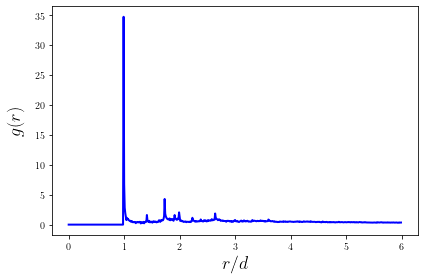

In [323]:
#Plot radial distribution function
fig,ax=plt.subplots(1,1,sharex=True,figsize=(6,4))
ax.plot(rdf_s[:,0],rdf_s[:,1],linestyle='solid',linewidth=2,color='blue')
ax.set_ylabel(r'$g(r)$',size=18,labelpad=10)
ax.set_xlabel(r'$r/d$',size=18)
plt.tight_layout()
#plt.savefig(fig_folder_name+'/Rdf'+file_name+'.png')
plt.show()

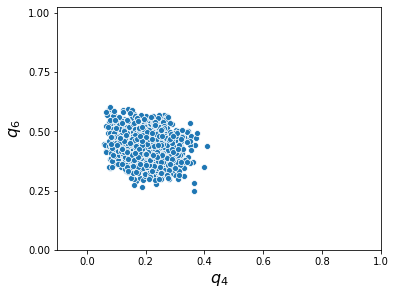

In [52]:
#Scatter plot of the q4 and q6 pairs for spheres in the bulk
fig,ax=plt.subplots(1,1,figsize=(5.6,4.2))
sns.scatterplot(x='q4',y='q6',data=original_data.loc[(original_data['z']>zmin) & (original_data['z']<zmax)])
plt.xlabel(r'$q_4$',size=16,labelpad=5)
plt.ylabel(r'$q_6$',size=16,labelpad=5)
plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.yticks([0,0.25,0.5,0.75,1])
plt.xlim(-0.1,1)
plt.ylim(0,1.025)
plt.tight_layout()
#plt.savefig(fig_folder_name+'/q4andq6updated'+'.png')
plt.show()

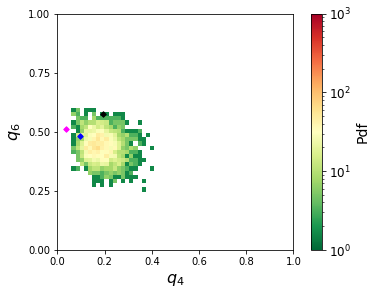

In [53]:
#2d histogram of the q4 and q6 pairs for spheres in the bulk, the values for 
#ideal bcc, fcc, hcp crystals are also shown
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax=plt.subplots(1,1,figsize=(5.6,4.2))
plt.hist2d(original_data.loc[(original_data['z']>zmin) & (original_data['z']<zmax)]['q4'],original_data.loc[(original_data['z']>zmin) & (original_data['z']<zmax)]['q6'],bins=20,density=True,cmap = "RdYlGn_r", norm = colors.LogNorm(vmin=1,vmax=1000))
cbar = plt.colorbar(ticks=[1,10,100,1000],shrink=1)
cbar.set_label(r'Pdf',size=14)
cbar.ax.tick_params(labelsize='12')
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.yaxis.offsetText.set(size=12)
ax.set_xlabel(r'$q_4$',fontsize=16,labelpad=5)
ax.set_ylabel(r'$q_6$',fontsize=16,labelpad=5)
plt.scatter(0.191,0.575,s=15,color='black',marker='D')
plt.scatter(0.097,0.484,s=15,color='blue',marker='D')
plt.scatter(0.036,0.511,s=15,color='magenta',marker='D')
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_aspect('equal')
plt.tight_layout()
#plt.savefig((fig_folder_name+'/q4andq6updated'+file_name+'.png',bbox_inches='tight')
plt.show()

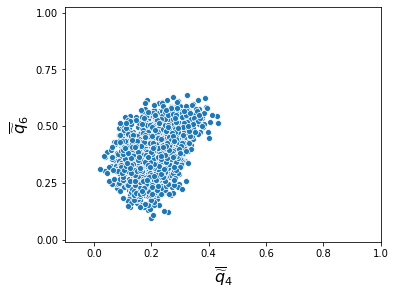

In [54]:
#Scatter plot of the new q4 and q6 pairs for spheres in the bulk
fig,ax=plt.subplots(1,1,figsize=(5.6,4.2))
sns.scatterplot(x='q4tildabar',y='q6tildabar',data=original_data.loc[(original_data['z']>zmin) & (original_data['z']<zmax)])
plt.xlabel(r'$\overline{\widetilde{q}}_{4}$',size=16,labelpad=5)
plt.ylabel(r'$\overline{\widetilde{q}}_{6}$',size=16,labelpad=5)
plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.yticks([0,0.25,0.5,0.75,1])
plt.xlim(-0.1,1)
plt.ylim(-0.01,1.025)
plt.tight_layout()
#plt.savefig(fig_folder_name+'/newq4andq6updated'+file_name+'.png')
plt.show()